## Importing necessary libraries

In [1]:
import os
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

## Downloading dataset
We will download the [BBC News Classification](https://www.kaggle.com/competitions/learn-ai-bbc/data) dataset from Kaggle.

In [2]:
! pip install -q kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kikugo","key":"37a93e7ee1d2c922c601706a9409dcf3"}'}

In [4]:
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle/kaggle.json

-rw------- 1 root root 62 Aug 27 22:42 /root/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c learn-ai-bbc

100% 1.85M/1.85M [00:01<00:00, 1.96MB/s]
100% 1.85M/1.85M [00:01<00:00, 1.73MB/s]


In [6]:
!mkdir /content/data
!unzip -q /content/learn-ai-bbc.zip -d /content/data/
!rm -r /content/learn-ai-bbc.zip

In [7]:
os.listdir('/content/data/')

['BBC News Sample Solution.csv', 'BBC News Train.csv', 'BBC News Test.csv']

In [8]:
with open("/content/data/BBC News Train.csv", 'r') as csvfile:
    print(f"CSV header:\n {csvfile.readline()}")
    print(f"First data point:\n {csvfile.readline()}")

CSV header:
 ArticleId,Text,Category

First data point:
 1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green li

In [9]:
with open("/content/data/BBC News Test.csv", 'r') as csvfile:
    print(f"CSV header:\n {csvfile.readline()}")
    print(f"First data point:\n {csvfile.readline()}")

CSV header:
 ArticleId,Text

First data point:
 1018,qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.



As you can see, each data point in the training set is composed of:

1. an `ArticleId`
2. the `Text` of the news article, and
3. the `Category` of the article.

And they are separated by commas.

The `testing` set, however doesn't have any `Category` feature, and it's our job is to determine the most likely category of a given a article from the `test` dataset.

## Setting up hyperparameters

Now, let's define some hyperparaters that will be used in data preparation and pre-processing tasks.

In [10]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Loading and pre-processing data

First, let's start with the definiton of the methods to remove stopwords from the training texts.

In [11]:
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords(sentence):
    sentence = sentence.lower()
    word_list = sentence.split()
    words = [w for w in word_list if w not in stopwords_list]
    return " ".join(words)

def lemmatize_sentence(sentence):
    words = sentence.split()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(lemmatized_words)

def preprocess_sentence(sentence):
    sentence = remove_stopwords(sentence)
    return lemmatize_sentence(sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now, let's define the `parse_data_from_file()` method to load training dataset and extract texts and corresponding categories.

In [12]:
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[2])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

Now, let's call the `parse_data_from_file()` method and check out the detailed information about the training dataset.

In [13]:
sentences, labels = parse_data_from_file("/content/data/BBC News Train.csv")

print(f"Number of sentences: {len(sentences)}")
print(f"Length of the first sentence (after stopword removal): {len(sentences[0].split())}")
print(f"Number of labels: {len(labels)}")
print(f"First 10 labels: {labels[:10]}")
print(f"Average sentence length: {sum(len(sentence.split()) for sentence in sentences) / len(sentences)}")

Number of sentences: 1490
Length of the first sentence (after stopword removal): 193
Number of labels: 1490
First 10 labels: ['business', 'business', 'business', 'tech', 'business', 'politics', 'sport', 'entertainment', 'business', 'entertainment']
Average sentence length: 222.7771812080537


## Train & Validation Split

The deep learning model we will use to classify news articles requires the training dataset splitted into: 1) a `train` set, and 2) a `validation` set.

Let's define the `train_val_split()` method to split the training dataset into training and validation sentences and labels given a training split size set as `TRAINING_SPLIT` earlier.


In [14]:
def train_val_split(sentences, labels, training_split):
    train_size = int(len(sentences) * training_split)
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]
    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

Now, it's time to call the `train_val_split()` method and split the training dataset into train/validation splits.

In [15]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"Number of sentences for training: {len(train_sentences)} \n")
print(f"Number of labels for training: {len(train_labels)}\n")
print(f"Number of sentences for validation: {len(val_sentences)} \n")
print(f"Number of labels for validation: {len(val_labels)}")

Number of sentences for training: 1192 

Number of labels for training: 1192

Number of sentences for validation: 298 

Number of labels for validation: 298


## Tokenization: Sequences and Padding

First, we define the `fit_tokenizer()` method to return a `Tokenizer` for us that has been fitted to the training sentences.

In [16]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

Now, let's call the `fit_tokenizer()` method to fit the `Tokenizer` to the training sentences.

In [17]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Number of words in the vocabulary: {len(word_index)}\n")

Number of words in the vocabulary: 22631



Since we already tokenize the traning sentences, now, let's define and run the following `seq_and_pad()` method to convert each text data point into its padded sequence representation.

In [18]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences,
                                     maxlen=maxlen,
                                     padding=padding,
                                     truncating='post')

    return padded_sequences

Run the `seq_and_pad()` method and get the padded training sequences.

In [19]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Shape of padded training sequences: {train_padded_seq.shape}\n")
print(f"Shape of padded validation sequences: {val_padded_seq.shape}")

Shape of padded training sequences: (1192, 120)

Shape of padded validation sequences: (298, 120)


Finally, we need to tokenize the labels. Let's define the `tokenize_labels()` method to achieve our goal.

In [20]:
def tokenize_labels(all_labels, split_labels):
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(all_labels)
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    label_seq_np = np.array(label_seq)-1

    return label_seq_np

Call the `tokenizer_labels()` method to tokenize the labels and convert into numpy arrays.

In [21]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"Shape of tokenized labels of the training set: {train_label_seq.shape}\n")
print(f"Shape of tokenized labels of the validation set: {val_label_seq.shape}\n")
print(f"First 5 labels of the training set:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set:\n{val_label_seq[:5]}\n")

Shape of tokenized labels of the training set: (1192, 1)

Shape of tokenized labels of the validation set: (298, 1)

First 5 labels of the training set:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set:
[[3]
 [3]
 [2]
 [1]
 [4]]



## Text classification model

Our training data is already prepared to be fed into a deep neural network that will work as a text classifier to classify each news article as part of being a certain category.

Now, it's time to define our model. Let's define the model architecture by completing the following `model()` method.

In [22]:
def model(num_words, embedding_dim, maxlen, lstm1_dim, lstm2_dim, num_categories):
    tf.random.set_seed(123)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
        tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Before generating the model using `model()`, let's find out how many unique categories the training dataset have.

In [23]:
num_unique_categories = np.unique(labels)
print(f'Number of unique categories in the training dataset: {len(num_unique_categories)}')

Number of unique categories in the training dataset: 5


Now, let's create the model first.

In [24]:
lstm1_dim = 32
lstm2_dim = 16
model = model(NUM_WORDS, EMBEDDING_DIM, MAXLEN, lstm1_dim, lstm2_dim, len(num_unique_categories))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


And train the model with prepared training datasets.

In [25]:
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.2616 - loss: 1.5995 - val_accuracy: 0.3356 - val_loss: 1.5488
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3851 - loss: 1.4526 - val_accuracy: 0.4530 - val_loss: 1.1482
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5782 - loss: 1.0388 - val_accuracy: 0.7819 - val_loss: 0.8362
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7296 - loss: 0.7581 - val_accuracy: 0.7685 - val_loss: 0.6482
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8123 - loss: 0.5153 - val_accuracy: 0.7181 - val_loss: 0.7166
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8261 - loss: 0.4627 - val_accuracy: 0.8389 - val_loss: 0.4865
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8522 - loss: 0.3824 - val_accuracy: 0.7081 - val_loss: 0.5896
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8494 - loss: 0.3837 - val_accuracy: 0.5738 - 

## Evaluating Model Training

Now, let check how the model performed during the training process.

In [26]:
def evaluate_model(history):
    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(epoch_accuracy)), epoch_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(epoch_val_accuracy)), epoch_val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

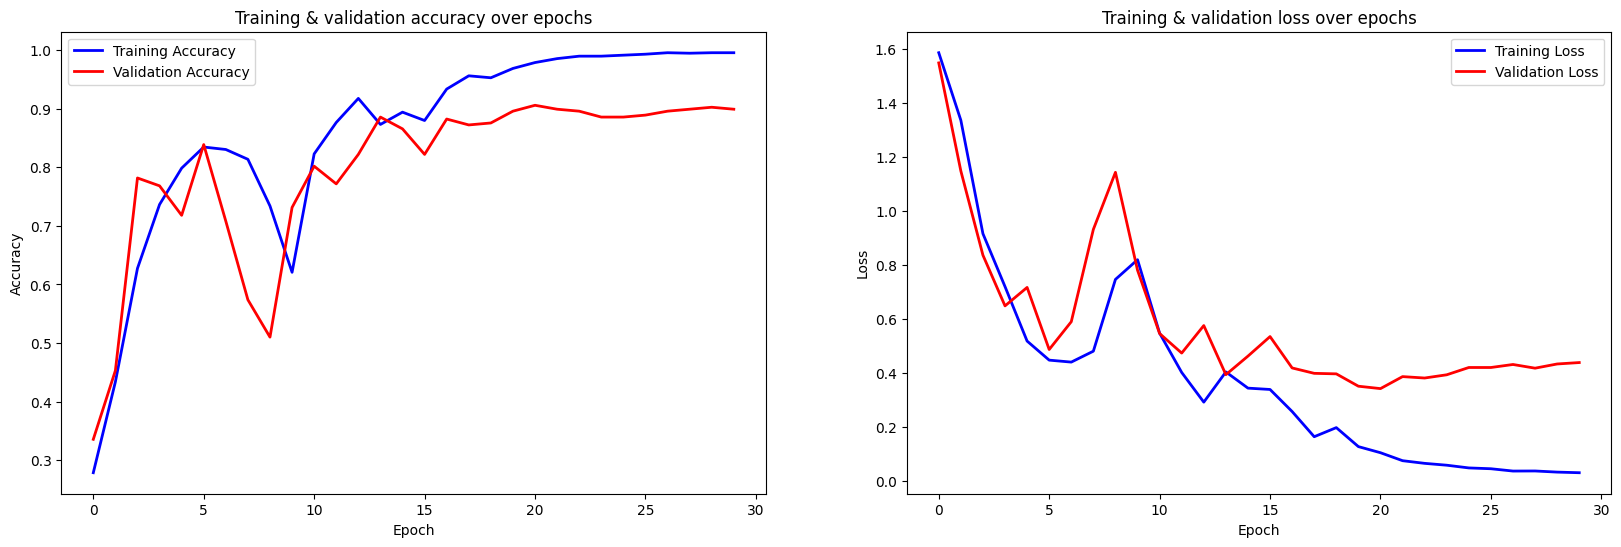

In [27]:
evaluate_model(history)

## Prediction

Now that our model is successfully trained, let's check how it performs for the test prediction tasks. Before performing prediction task, we need to preprocess our test dataset.

Let's start with the removal of stopwords from test dataset first.

In [28]:
def load_test_data(filename):
    test_sentences = []
    test_ids = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            test_ids.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            test_sentences.append(sentence)
    return test_ids, test_sentences

test_ids, test_sentences = load_test_data("/content/data/BBC News Test.csv")

print(f"Number of sentences in the test dataset: {len(test_sentences)}\n")
print(f"Number of words in the 1st sentence (after removing stopwords). {len(test_sentences[0].split())}\n")

Number of sentences in the test dataset: 735

Number of words in the 1st sentence (after removing stopwords). 89



After removing stopwords from the test dataset, we must convert the sentences to the token sequences and later to the padded sequences. We can use the same `fit_tokenizer()` and `seq_and_pad()` methods we used for training dataset to achieve our goal here.

In [29]:
test_tokenizer = fit_tokenizer(test_sentences, NUM_WORDS, OOV_TOKEN)

test_word_index = test_tokenizer.word_index

test_padded_seq = seq_and_pad(test_sentences, test_tokenizer, PADDING, MAXLEN)

print(f"Number of words in the test vocabulary: {len(test_word_index)}\n")
print(f"Shape of padded training sequences: {test_padded_seq.shape}\n")

Number of words in the test vocabulary: 18582

Shape of padded training sequences: (735, 120)



#### Now, let's make prediction on the test dataset.

In [30]:
predictions = model.predict(test_padded_seq)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [31]:
predicted_classes = predictions.argmax(axis=1)
print(f'Predicted classes:\n\n {predicted_classes}')

Predicted classes:

 [3 4 0 4 3 1 4 1 1 3 4 1 1 2 0 0 1 2 3 0 1 1 2 1 1 4 0 2 3 2 1 4 3 1 1 2 3
 1 3 3 3 0 4 4 2 4 1 3 0 1 2 2 2 2 4 3 0 2 3 2 2 0 0 0 2 1 1 0 0 2 2 1 0 4
 4 1 0 4 0 1 2 0 1 1 4 2 2 4 1 0 2 2 2 0 1 1 4 3 0 2 0 1 1 3 0 4 1 3 2 0 2
 2 0 3 3 2 1 4 0 1 2 4 0 3 0 3 2 4 1 0 4 1 2 0 2 0 1 0 2 3 3 3 3 4 0 4 1 0
 1 2 1 2 2 2 0 3 3 3 2 1 4 0 4 0 3 4 1 1 1 4 1 1 3 3 3 0 4 4 0 4 4 0 1 4 4
 1 2 3 3 4 1 1 4 3 3 2 2 0 0 3 2 2 2 4 3 3 2 4 3 2 1 1 1 3 1 3 3 0 2 3 0 1
 1 4 4 0 3 0 2 0 0 4 4 4 0 4 3 1 1 3 1 2 2 2 2 2 0 0 2 1 2 4 0 0 4 4 2 0 3
 2 0 1 2 0 3 2 0 3 4 4 3 2 1 2 0 2 4 4 0 0 0 0 0 1 0 2 3 1 1 2 4 2 4 0 2 3
 2 3 3 2 3 0 0 0 2 3 2 2 0 4 1 1 2 0 1 4 3 2 4 4 1 1 0 4 0 0 2 2 0 4 1 1 2
 4 2 4 2 4 4 4 2 0 2 2 0 3 2 0 3 3 3 3 1 3 3 2 3 1 2 3 1 3 1 1 2 1 1 0 1 2
 0 3 2 3 0 4 4 1 3 2 0 0 0 0 1 1 1 1 3 0 0 2 0 4 1 1 0 1 3 1 2 0 3 1 2 4 2
 1 0 3 4 4 0 3 2 4 4 3 3 0 0 2 0 2 1 0 0 0 4 4 2 1 0 0 3 1 0 3 2 0 0 4 0 4
 4 0 0 0 0 4 1 2 2 4 2 1 2 1 3 4 0 4 3 4 2 2 3 2 4 2 2 0 2 0 3 2 0 0 0 3 2
 4 3

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(set(labels)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_padded_seq, train_label_seq, epochs=60, validation_split=0.2, batch_size=32,
                    validation_data=(val_padded_seq, val_label_seq),
                    callbacks=[early_stopping, model_checkpoint])
best_model = tf.keras.models.load_model('best_model.keras')
val_loss, val_accuracy = best_model.evaluate(val_padded_seq, val_label_seq)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2723 - loss: 1.6052 - val_accuracy: 0.2148 - val_loss: 1.5873
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2525 - loss: 1.5749 - val_accuracy: 0.4094 - val_loss: 1.5312
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4443 - loss: 1.5026 - val_accuracy: 0.6040 - val_loss: 1.3979
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5986 - loss: 1.3464 - val_accuracy: 0.7315 - val_loss: 1.1852
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7599 - loss: 1.1110 - val_accuracy: 0.8423 - val_loss: 0.9398
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8649 - loss: 0.8574 - val_accuracy: 0.8658 - val_loss: 0.7269
Epoch 7/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9025 - loss: 0.6482 - val_accuracy: 0.8859 - val_loss: 0.5681
Epoch 8/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9225 - loss: 0.4930 - val_accuracy: 0.9094 - val_loss

In [33]:
best_model = tf.keras.models.load_model('best_model.keras')
predictions = best_model.predict(test_padded_seq)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [34]:
predicted_labels = np.argmax(predictions, axis=1)
unique_labels = np.unique(labels)
label_to_category = {i: label for i, label in enumerate(unique_labels)}
predicted_categories = [label_to_category[label] for label in predicted_labels]
submission_df = pd.DataFrame({
    'ArticleId': test_ids,
    'Category': predicted_categories
})

submission_df.to_csv('Submission.csv', index=False)

print("Submission.csv")
submission_df.head(10)

Submission.csv


,ArticleId,Category
0,1018,business
1,1319,entertainment
2,1138,sport
3,459,entertainment
4,1020,business
5,51,politics
6,2025,politics
7,1479,tech
8,27,entertainment
9,397,tech
